# Self-Driving Car Engineer Nanodegree
## Deep Learning
## Project: Build a Traffic Sign Recognition Classifier


The goals / steps of this project are the following:
* Load the data set 
* Explore, summarize and visualize the data set
* Design, train and test a model architecture
* Use the model to make predictions on new images
* Analyze the softmax probabilities of the new images
* Summarize the results with a written report

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# load training and testing data

dataset_dir = 'traffic-signs-data'  # TODO 
training_file = dataset_dir + '/train.p'
validation_file = dataset_dir + '/valid.p'
testing_file = dataset_dir + '/test.p'


with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## Step 1: Dataset Summary & Exploration¶

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Number of training examples
n_train = len(X_train)

# Number of validation examples.
n_valid = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# Shape of an traffic sign image
image_shape = X_train[0].shape

# Number of unique classes/labels there are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Visualize Data

View a sample from the dataset.

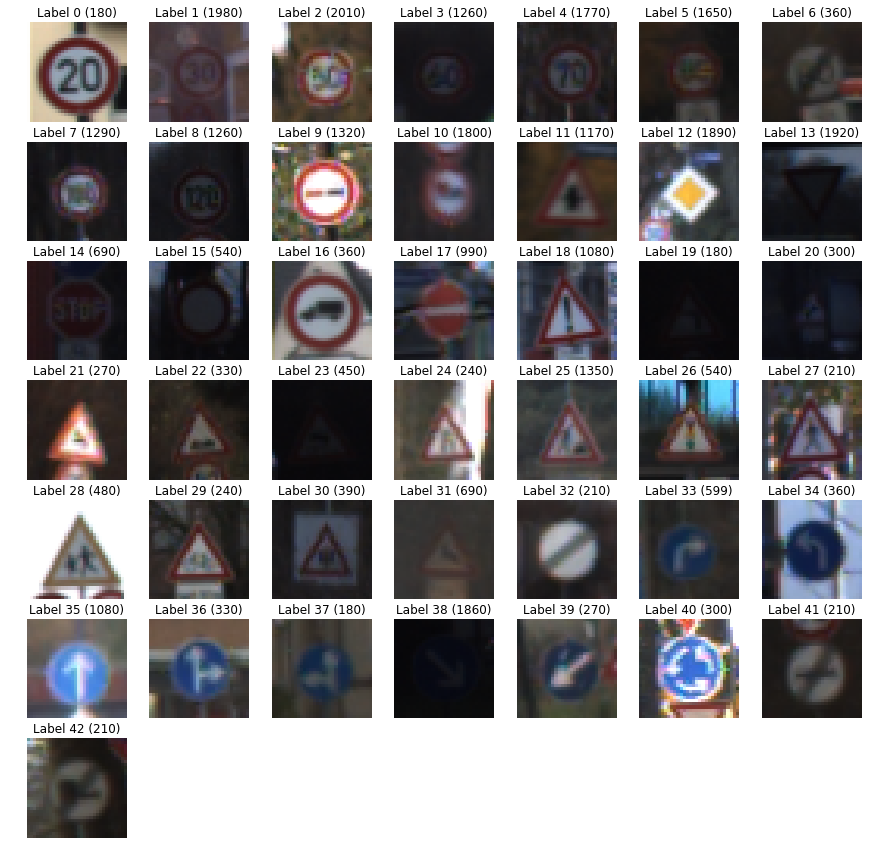

In [3]:
# Display the first image of each label
def display_images_and_labels(images, labels):
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        index=np.nonzero(labels==label)[0][0]
        image = images[index]
        plt.subplot(7, 7, i)  # A grid of 7 rows x 7 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, len(np.nonzero(labels==label)[0])))
        i += 1
        _ = plt.imshow(image)
    plt.show()
display_images_and_labels(X_train, y_train)

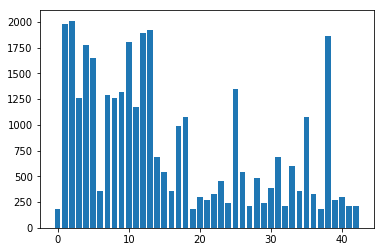

In [4]:
# Count how many samples in each category 
fig = plt.figure()
ax = fig.add_subplot(111)
values, counts = np.unique(y_train, return_counts=True)
ax.bar(values,counts)
fig.savefig('category_counts.png')

## Step 2: Design and Test a Model Architecture

## Preprocess Data

In [5]:
import scipy.ndimage as ndimage
# Augmentation
def augment(X_dataset, y_dataset):
    part_to_augment = 3
    degree_range = [-15, 15] #range for random rotate 
    shift_range = [-6, 6] #range for random image shift 
    decimals = 10
    train_images_count = X_dataset.shape[0]
    
    unique, counts = np.unique(y_dataset, return_counts=True)
    quantity_to_augment = 2000 - counts  # for categories that has lower than 2000 samples, augment fake data 
    quantity_to_augment[np.where(quantity_to_augment < 0)] = 0
    classes_to_augment = np.array((unique, quantity_to_augment)).T
    
    rotated_ids = np.array([], dtype=np.int32)
    for [klass, quantity] in classes_to_augment:
        image_available_indexes = np.where(y_dataset == klass)[0]
        sample = np.random.choice(image_available_indexes, quantity)
        rotated_ids = np.concatenate((rotated_ids, sample))
        
    y_train_augmented = y_dataset[rotated_ids]
    augmented_images_length = len(rotated_ids)
    X_train_augmented = np.ones((augmented_images_length,) + X_dataset.shape[1:4], dtype=np.uint8)
    for index in range(0, len(rotated_ids)):
        i = rotated_ids[index]
        angle = np.random.randint(low=degree_range[0]*decimals, high=degree_range[1]*decimals, size=1)/decimals
        shift = np.random.randint(low=shift_range[0], high=shift_range[1], size=1)
        augmented_image = ndimage.interpolation.rotate(X_dataset[i], angle, reshape=False, mode='nearest')
        augmented_image = ndimage.shift(augmented_image, (shift, shift, 0), mode='nearest')
        X_train_augmented[index] = augmented_image
    return [X_train_augmented, y_train_augmented, rotated_ids]

X_train_augmented, y_train_augmented, rotated_ids  = augment(X_train, y_train)

In [6]:
#concatenate original data with augomented data 
X_train_concat = np.concatenate((X_train, X_train_augmented))
y_train_concat = np.concatenate((y_train, y_train_augmented))

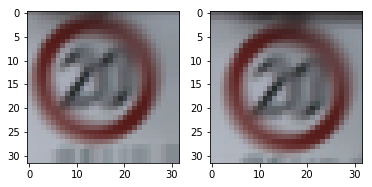

In [7]:
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)  # A grid of 1 row x 2 columns, first image 
index=1
image = X_train_augmented[index].squeeze() 
plt.imshow(image, cmap="gray")

plt.subplot(1, 2, 2)  # A grid of 1 row x 2 columns, second image 
image = X_train[rotated_ids[index]].squeeze()
plt.imshow(image, cmap="gray")
plt.savefig('before_and_after_augment.jpg')

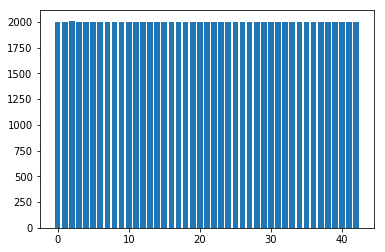

In [8]:
# Count how many samples in each category again
fig = plt.figure()
ax = fig.add_subplot(111)
values, counts = np.unique(y_train_concat, return_counts=True)
ax.bar(values,counts)
fig.savefig('after_augmentation_category_counts.png')

X_train=X_train_concat
y_train=y_train_concat

Image Shape:(32, 32, 3)


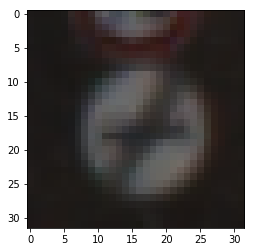

In [9]:
plt.imshow(X_train[0].squeeze())
print ("Image Shape:{}".format(X_train[0].shape))
plt.savefig('before_grayscale.jpg')

#convert color images to gray images 
import cv2
def grayscale(X_set):
    new_Set=[]
    n_set=len(X_set)
    for i in range(0,n_set):
        image = X_set[i]
        image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        new_Set.append(image)
    new_Set=np.reshape(new_Set,(-1,32,32,1))
    return new_Set

X_train=grayscale(X_train)
X_valid=grayscale(X_valid)
X_test=grayscale(X_test)

Image Shape:(32, 32, 1)


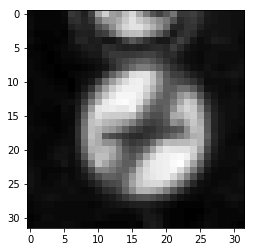

In [10]:
plt.imshow(X_train[0].squeeze(),cmap='gray')
print ("Image Shape:{}".format(X_train[0].shape))
plt.savefig('after_grayscale.jpg')

In [11]:
#normalize the gray image 
def normalize(X_set):
    new_Set=[]
    n_set=len(X_set)
    for i in range(0,n_set):
        img = X_set[i]
        # normalize image
        normalizedImg = np.zeros(shape=img.shape)
        normalizedImg = cv2.normalize(img, dst = normalizedImg, alpha=0, beta=25, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        # Add back the 3rd dimension
        if len(normalizedImg.shape) < 3:
            normalizedImg = np.expand_dims(normalizedImg, axis= 2)
        new_Set.append(normalizedImg)
    return new_Set
X_train=normalize(X_train)
X_valid=normalize(X_valid)
X_test=normalize(X_test)

In [12]:
#shuffle the training data 
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

In [21]:
import tensorflow as tf

EPOCHS = 20
BATCH_SIZE = 128
dropout=0.7

## Features and Labels

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.


In [22]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

In [23]:
from tensorflow.contrib.layers import flatten

# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1

# Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
conv1_b = tf.Variable(tf.zeros(6))
conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

# Activation.
conv1 = tf.nn.relu(conv1)

# Pooling. Input = 28x28x6. Output = 14x14x6.
conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# Layer 2: Convolutional. Output = 10x10x16.
conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
conv2_b = tf.Variable(tf.zeros(16))
conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

# Activation.
conv2 = tf.nn.relu(conv2)

# Pooling. Input = 10x10x16. Output = 5x5x16.
conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# Flatten. Input = 5x5x16. Output = 400.
fc0   = flatten(conv2)

# Layer 3: Fully Connected. Input = 400. Output = 120.
fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
fc1_b = tf.Variable(tf.zeros(120))
fc1   = tf.matmul(fc0, fc1_W) + fc1_b

# Activation.
fc1    = tf.nn.relu(fc1)

# Dropout
fc1    = tf.nn.dropout(fc1, dropout)

# Layer 4: Fully Connected. Input = 120. Output = 84.
fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
fc2_b  = tf.Variable(tf.zeros(84))
fc2    = tf.matmul(fc1, fc2_W) + fc2_b

# Activation.
fc2    = tf.nn.relu(fc2)

# Dropout
fc2    = tf.nn.dropout(fc2, dropout)

# Layer 5: Fully Connected. Input = 84. Output = 43.
fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
fc3_b  = tf.Variable(tf.zeros(43))
logits = tf.matmul(fc2, fc3_W) + fc3_b



In [24]:
rate = 0.001
reg=0.001
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)+ reg*tf.nn.l2_loss(fc1_W) + \
                reg*tf.nn.l2_loss(fc2_W) + reg*tf.nn.l2_loss(fc3_W) #added regularization feature 
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [25]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_accuracy / num_examples, total_loss / num_examples 

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.


In [26]:
training_accuracy_history=[]
validation_accuracy_history=[]
training_loss_history=[]
validation_loss_history=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        training_accuracy, training_loss = evaluate(X_train,y_train)
        validation_accuracy, validation_loss = evaluate(X_valid, y_valid)
        
        # Log accuracy and loss every epoch
        training_accuracy_history.append(training_accuracy)
        validation_accuracy_history.append(validation_accuracy)
        training_loss_history.append(training_loss)
        validation_loss_history.append(validation_loss)
        
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.675
Validation Accuracy = 0.713

EPOCH 2 ...
Training Accuracy = 0.814
Validation Accuracy = 0.816

EPOCH 3 ...
Training Accuracy = 0.862
Validation Accuracy = 0.855

EPOCH 4 ...
Training Accuracy = 0.888
Validation Accuracy = 0.870

EPOCH 5 ...
Training Accuracy = 0.910
Validation Accuracy = 0.885

EPOCH 6 ...
Training Accuracy = 0.915
Validation Accuracy = 0.887

EPOCH 7 ...
Training Accuracy = 0.929
Validation Accuracy = 0.904

EPOCH 8 ...
Training Accuracy = 0.936
Validation Accuracy = 0.912

EPOCH 9 ...
Training Accuracy = 0.937
Validation Accuracy = 0.902

EPOCH 10 ...
Training Accuracy = 0.934
Validation Accuracy = 0.911

EPOCH 11 ...
Training Accuracy = 0.947
Validation Accuracy = 0.916

EPOCH 12 ...
Training Accuracy = 0.950
Validation Accuracy = 0.923

EPOCH 13 ...
Training Accuracy = 0.948
Validation Accuracy = 0.922

EPOCH 14 ...
Training Accuracy = 0.957
Validation Accuracy = 0.930

EPOCH 15 ...
Training Accuracy = 0.954
Valid

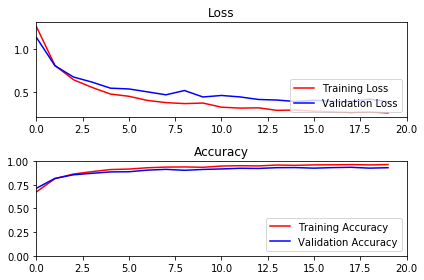

In [27]:
loss_plot = plt.subplot(2,1,1)
loss_plot.set_title('Loss')
loss_plot.plot(training_loss_history, 'r', label='Training Loss')
loss_plot.plot(validation_loss_history, 'b', label='Validation Loss')
loss_plot.set_xlim([0, EPOCHS])
loss_plot.legend(loc=4)
acc_plot = plt.subplot(2,1,2)
acc_plot.set_title('Accuracy')
acc_plot.plot(training_accuracy_history,'r', label='Training Accuracy')
acc_plot.plot(validation_accuracy_history, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([0, EPOCHS])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.


In [28]:
#check training accuracy, for comparison with validation accuracy 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)[0]
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.902


## Step 3. Test a Model on New Images
Test model on five pictures of German traffic signs from the web and predict the traffic sign type.
signnames.csv: contains mappings from the class id (integer) to the actual sign name.

In [29]:
# Load an additional set of images on web
y_add = np.array([1, 14, 40, 12, 27]) 
X_add = []
for i in range(5):
    image = cv2.imread('traffic-signs-data/additional/' + str(i + 1) + '.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X_add.append(image)

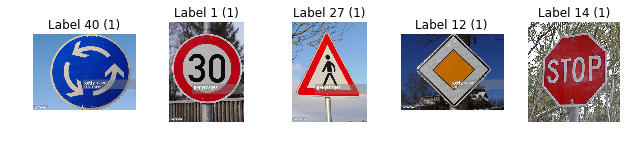

In [30]:
# plot images 
display_images_and_labels(X_add, y_add)

In [31]:
#preprocess image 
def resize_image(X_set):
    new_Set=[]
    n_set=len(X_set)
    for i in range(0,n_set):
        image = X_set[i]
        image = cv2.resize(image, (32,32))
        new_Set.append(image)
    new_Set=np.reshape(new_Set,(-1,32,32,3))
    return new_Set

X_add=resize_image(X_add)
X_add=grayscale(X_add)
X_add=normalize(X_add)

Image Shape:(32, 32, 1)


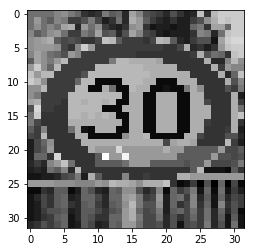

In [32]:
plt.imshow(X_add[0].squeeze(),cmap='gray')
print ("Image Shape:{}".format(X_add[0].shape))

In [33]:
#Evaluate model 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_add, y_add)[0]
    print("5 images Accuracy = {:.3f}".format(test_accuracy))

5 images Accuracy = 0.800


## Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [44]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmax = tf.nn.softmax(logits)
    result = sess.run(softmax, feed_dict={x:X_add})
    values, indices = tf.nn.top_k(result, 5)
    probs = sess.run(values)
    predictions = sess.run(indices)
    print (predictions)
    print (probs)

[[ 0  1  4 18  6]
 [14 38 17 13 33]
 [40 37 39 27 14]
 [12 40 39 14 33]
 [27 24 18 28 11]]
[[  9.79834139e-01   1.53847300e-02   4.22899704e-03   1.65056248e-04
    9.86562518e-05]
 [  9.90796089e-01   7.14431470e-03   8.34851584e-04   4.62959317e-04
    2.19367023e-04]
 [  9.73165989e-01   2.04627030e-02   5.95692219e-03   2.45149480e-04
    6.32660813e-05]
 [  8.98085475e-01   1.00492157e-01   5.13489649e-04   4.72170621e-04
    1.80467774e-04]
 [  7.53833771e-01   2.45217115e-01   5.37009153e-04   4.03766986e-04
    5.21021457e-06]]
